# Multi-Layer Perceptron (Neural Network)
## Research Question: "Predict whether a stop and search will conclude in police action".

#### In this notebook we attempt to answer the research question using the data set (https://www.kaggle.com/sohier/london-police-records?select=london-stop-and-search.csv), and a Multilayer Perceptron.

In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import util
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, Adadelta, SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from os.path import exists
import util_smote as usm

#SMOTE
from imblearn.over_sampling import SMOTE


Using TensorFlow backend.


## Cleaning the Data

In [2]:
data = pd.read_csv("data.csv")
data = util.data_cleaner(data)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 165651 entries, 0 to 302621
Data columns (total 10 columns):
 #   Column                     Non-Null Count   Dtype              
---  ------                     --------------   -----              
 0   Type                       165651 non-null  object             
 1   Date                       165651 non-null  datetime64[ns, UTC]
 2   Latitude                   165651 non-null  float64            
 3   Longitude                  165651 non-null  float64            
 4   Gender                     165651 non-null  object             
 5   Age range                  165651 non-null  object             
 6   Officer-defined ethnicity  165651 non-null  object             
 7   Legislation                165651 non-null  object             
 8   Object of search           165651 non-null  object             
 9   Outcome                    165651 non-null  object             
dtypes: datetime64[ns, UTC](1), float64(2), object(7)
memory 

## Encoding Data

In [7]:
data_encoded, encoders = util.data_encoder(data)

outcome_classes = encoders["Outcome Encoder"].classes_

data_encoded.head()

,Type,Date,Latitude,Longitude,Gender,Age range,Officer-defined ethnicity,Legislation,Object of search,Outcome
0,1,0,51.512286,-0.114491,1,1,0,4,8,6
1,1,0,51.512286,-0.114491,1,1,0,4,8,6
2,1,1,51.512286,-0.114491,1,1,4,4,8,6
4,0,2,51.512286,-0.114491,1,1,4,4,8,6
5,1,3,51.512286,-0.114491,1,1,0,3,3,2


## Splitting the Data

In [9]:
#Splt into X and y, while one-hot-encoding the target
X,y = util.to_xy(df=data_encoded, target="Outcome")

# Split into features and target
# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

## The MLP

We start with a basic MLP:
- Input
- Hidden (64 unit, relu activation)
- Output (8 unit, softmax)

In [7]:
model = Sequential()
model.add(Dense(64, input_dim=9, activation='relu'))
model.add(Dense(8, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [8]:
%%time
model.fit(X_train,y_train,verbose=0,epochs=128)

In [9]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
print(f"Prediction\n{pred[:100]}")
y_compare = np.argmax(y_test,axis=1) 
print(f"Y test\n{y_compare[:100]}")
score = metrics.accuracy_score(y_compare, pred)
print(f"\nScore is {score}")

Prediction
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
Y test
[2 2 2 2 6 2 4 2 2 6 4 2 2 2 6 2 2 6 2 2 2 2 2 4 0 2 6 2 2 6 6 2 2 6 2 2 2
 2 2 2 2 2 2 5 2 2 4 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 2 6 2 2 7 2 6 2 2 2 6 2
 2 4 6 4 2 4 2 6 6 2 2 4 6 2 2 2 6 2 2 2 2 2 2 2 2 2]

Score is 0.6509613353053032


In [10]:
pred = model.predict(X_test)
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print(f"Final score (RMSE): {score}")

Final score (RMSE): 0.2559282183647156


In [11]:
# Save the model
model.save("./models/score(65)-input-hidden(64-relu)-Output(8-softmax).h5")

The model was able to predict test set 65% of the time. It is highly biased to predict class 2 ("Nothing found - no further action"), suggesting an underfit of the data.

## Adding More Hidden Layers

We try to add more layers to alleviate the underfitting of our model

In [14]:
model2 = Sequential()
model2.add(Dense(64, input_dim=9, activation='relu')) # Hidden 1
model2.add(Dense(64, activation='relu')) # Hidden 2
model2.add(Dense(8, activation='softmax')) # Ouput
model2.compile(loss='categorical_crossentropy', optimizer='adam')

In [15]:
%%time
model2.fit(X_train,y_train,verbose=0, epochs=128)

In [16]:
pred2 = model2.predict(X_test)
pred2 = np.argmax(pred2,axis=1)
print(f"Prediction\n{pred2[:100]}")
print(f"Y test\n{y_compare[:100]}")
score = metrics.accuracy_score(y_compare, pred2)
print(f"\nScore is {score}")

Prediction
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
Y test
[2 2 2 2 6 2 4 2 2 6 4 2 2 2 6 2 2 6 2 2 2 2 2 4 0 2 6 2 2 6 6 2 2 6 2 2 2
 2 2 2 2 2 2 5 2 2 4 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 2 6 2 2 7 2 6 2 2 2 6 2
 2 4 6 4 2 4 2 6 6 2 2 4 6 2 2 2 6 2 2 2 2 2 2 2 2 2]

Score is 0.6509311520932057


In [17]:
#Save the model
model.save("./models/score(65)-input-hidden(64-relu)-hidden(64-relu)-Output(8-softmax).h5")

Result not signficantly improved... still at around 66%.

# Sigmoid Activation

Let's try using sigmid instead of relu as our activation

In [26]:
model_s = Sequential()
model_s.add(Dense(500, input_dim=9, activation='sigmoid'))
model_s.add(Dense(500, input_dim=9, activation='sigmoid'))
model_s.add(Dense(8, activation='softmax'))
model_s.compile(loss='categorical_crossentropy', optimizer='adam')

In [27]:
%%time
model_s.fit(X_train,y_train,verbose=0,epochs=128)

CPU times: user 37min 11s, sys: 9min 37s, total: 46min 49s
Wall time: 9min 13s


In [29]:
pred = model_s.predict(X_test)
pred = np.argmax(pred,axis=1)
print(f"Prediction\n{pred[:100]}")
y_compare = np.argmax(y_test,axis=1) 
print(f"Y test\n{y_compare[:100]}")
score = metrics.accuracy_score(y_compare, pred)
print(f"\nScore is {score}")

Prediction
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
Y test
[2 2 2 2 6 2 4 2 2 6 4 2 2 2 6 2 2 6 2 2 2 2 2 4 0 2 6 2 2 6 6 2 2 6 2 2 2
 2 2 2 2 2 2 5 2 2 4 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 2 6 2 2 7 2 6 2 2 2 6 2
 2 4 6 4 2 4 2 6 6 2 2 4 6 2 2 2 6 2 2 2 2 2 2 2 2 2]

Score is 0.6509311520932057


Not improved

## With K-Fold


In [ ]:
model_k = Sequential()
model_k.add(Dense(64, input_dim=9, activation='relu')) # Hidden 1
model_k.add(Dense(64, activation='relu')) # Hidden 2
model_k.add(Dense(64, activation='relu')) # Hidden 3
model_k.add(Dense(8, activation='softmax')) # Ouput
model_k.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
util.k_fold_train(model=model_k, folds=2, data=data_encoded, is_NN=True)

In [ ]:
pred_k = model_k.predict(X_test)
pred_k= np.argmax(pred_k,axis=1)
print(f"Prediction\n{pred_k[:100]}")
y_compare = np.argmax(y_test,axis=1) 
print(f"Y test\n{y_compare[:100]}")
score = metrics.accuracy_score(y_compare, pred_k)
print(f"\nScore is {score}")

In [ ]:
#Save the model
model_k.save("./models/k_fold_3_hidden_2_folds_network.h5")

Score slightly higher, at 67%

# SMOTE Multiclass 

The issue seems to be that a single class dominates the other classes by far in terms of frequency.

Class 0: 0.02%     (41)
Class 1: 0.68%     (1121)
Class 2: 65.41%     (108353)
Class 3: 0.1%     (167)
Class 4: 10.74%     (17788)
Class 5: 2.31%     (3824)
Class 6: 19.96%     (33067)
Class 7: 0.78%     (1290)
Total: 165651


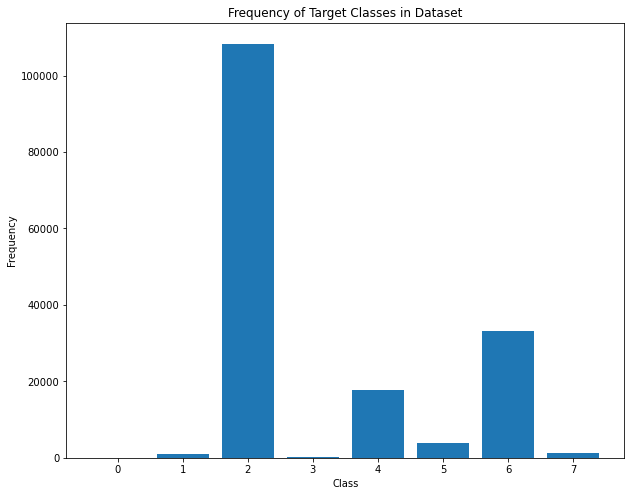

In [12]:
#The frequencies of each class in the dataset
usm.display_frequencies(data_encoded["Outcome"])

65% of the example targets belong to class 2! 

We can solve this by using SMOTE to generate artificial data for our minor classes.

### Preprocessing

Class 0: 12.5%     (86784)
Class 1: 12.5%     (86784)
Class 2: 12.5%     (86784)
Class 3: 12.5%     (86784)
Class 4: 12.5%     (86784)
Class 5: 12.5%     (86784)
Class 6: 12.5%     (86784)
Class 7: 12.5%     (86784)
Total: 694272


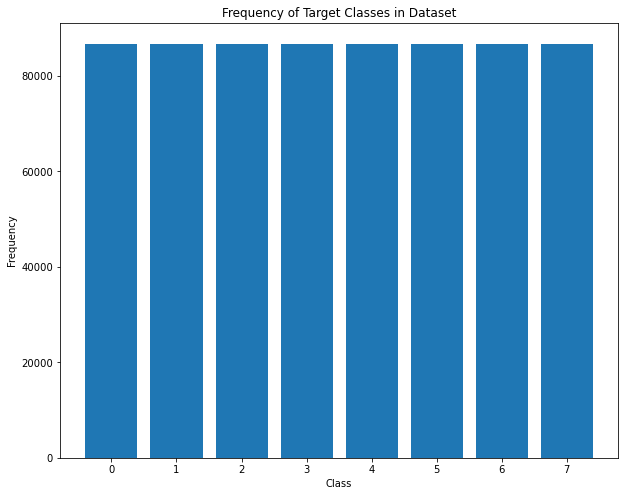

In [14]:
#Train/test split data_encoded
target = data_encoded["Outcome"]
features = data_encoded.drop('Outcome', axis=1)
X_train2, X_test2, y_train2, y_test2 = train_test_split(features, target, test_size=0.2, random_state=10)

oversample = SMOTE()
X_s, y_s = oversample.fit_resample(X_train2, y_train2)
#One hot encode target
y_hot = to_categorical(y_s)

usm.display_frequencies(y_s)

After using SMOTE, the frequencies of each class have been equalized.

We can begin training now...

### Build Model

In [15]:
#Train MLP
model = Sequential()

model_name = "model(9_3_64x10_8)"
path = f"./models/{model_name}.h5"

model.add(Dense(3, input_dim=9, activation='relu'))
for i in range(10):
    model.add(Dense(64, activation='relu'))

model.add(Dense(8, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Train

In [16]:
%%time
#Early Stopping callback- from ex7Part1 (lab 7 of Intro to AI module)
earlyStopping = EarlyStopping(monitor='loss', min_delta=0.00001, patience=4, verbose=1)

#Reduce learning ratr callbck - from https://keras.io/api/callbacks/reduce_lr_on_plateau/ 
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=2, min_lr=0.0000001, verbose=1)

for i in range(2):
    print(f"Starting era {i}...")
    if exists(path):
        print("Loading model...")
        del model
        model = load_model(path)
    model.fit(X_s, y_hot, epochs=10, batch_size=10, callbacks=[reduce_lr, earlyStopping])
    model.save(path)



Starting era 0...
Epoch 1/10
69428/69428 [==============================] - 65s 930us/step - loss: 1.8202 - accuracy: 0.2895
Epoch 2/10
69428/69428 [==============================] - 67s 968us/step - loss: 1.8199 - accuracy: 0.2889
Epoch 3/10
69428/69428 [==============================] - 68s 984us/step - loss: 1.8194 - accuracy: 0.2898
Epoch 4/10
69428/69428 [==============================] - 67s 969us/step - loss: 1.8193 - accuracy: 0.2895
Epoch 5/10
69428/69428 [==============================] - 67s 963us/step - loss: 1.8191 - accuracy: 0.2894
Epoch 6/10
69428/69428 [==============================] - 67s 962us/step - loss: 1.8189 - accuracy: 0.2893
Epoch 7/10
69428/69428 [==============================] - 68s 982us/step - loss: 1.8185 - accuracy: 0.2896
Epoch 8/10
69428/69428 [==============================] - 68s 981us/step - loss: 1.8184 - accuracy: 0.2895
Epoch 9/10
69428/69428 [==============================] - 67s 965us/step - loss: 1.8186 - accuracy: 0.2895
Epoch 10/10
69403/6

### Evaluate


Score is 2.064531707464308


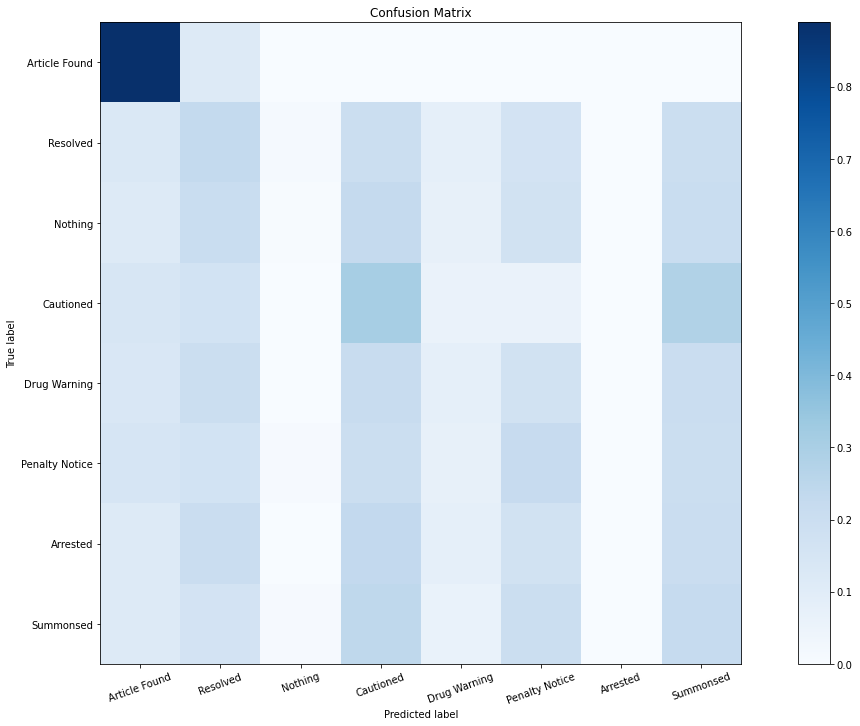

In [25]:
del model
model = load_model(path)

pred = model.predict(X_test2)
pred = np.argmax(pred, axis=1)
# print(f"Prediction\n{pred[:1000]}")
y_test_hot = to_categorical(y_test2)
y_compare = np.argmax(y_test_hot, axis=1) 
# print(f"Y test\n{y_compare[:1000]}")
score = metrics.accuracy_score(y_compare, pred)
print(f"\nScore is {score * 100}")

#Confusion Matrix
util.confusion_plot(y_test=y_compare, y_predictions=pred)

# SMOTE (With Bias to Class 2)

Matrix for SMOTE is better. However, it the score is signficantly worse- all of the models tested happened to be biased against predicting "Nothing", and the "Nothing" class accounts for 65% of the target.

We therefore try SMOTE again, but instead of equalizing all classes, we increase the frequency of the minor classes, while maintaining the dominance of class 2.

### Pre Processing

Class 0: 0.02%     (32)
Class 1: 0.67%     (891)
Class 2: 65.49%     (86784)
Class 3: 0.1%     (131)
Class 4: 10.74%     (14229)
Class 5: 2.27%     (3014)
Class 6: 19.95%     (26436)
Class 7: 0.76%     (1003)
Total: 132520


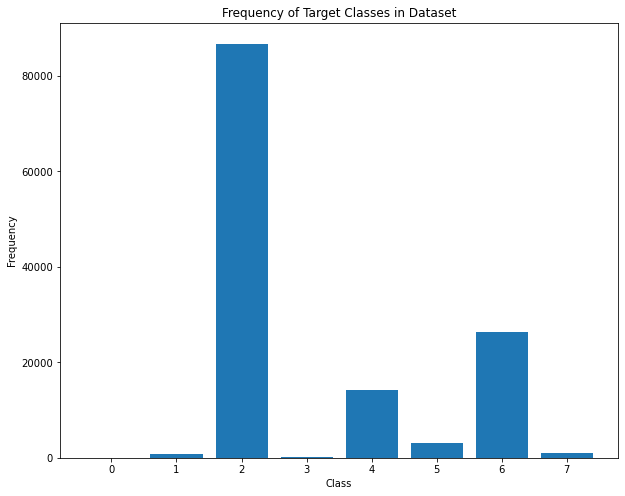

In [22]:
#Train/test split data_encoded
target = data_encoded["Outcome"]
features = data_encoded.drop('Outcome', axis=1)
X_train3, X_test3, y_train3, y_test3 = train_test_split(features, target, test_size=0.2, random_state=10)

#Before Smote
usm.display_frequencies(y_train3)

Class 0: 7.76%     (30000)
Class 1: 7.76%     (30000)
Class 2: 22.44%     (86784)
Class 3: 7.76%     (30000)
Class 4: 15.51%     (60000)
Class 5: 12.93%     (50000)
Class 6: 18.1%     (70000)
Class 7: 7.76%     (30000)
Total: 386784


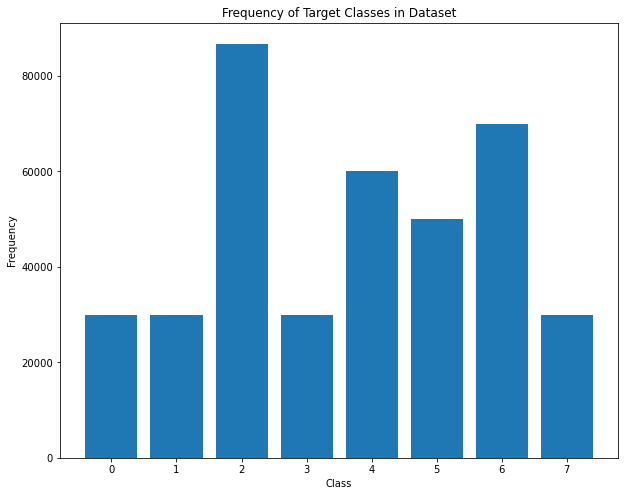

In [24]:
sampling_strategy = {0:30000, 1:30000, 2:86784, 3:30000, 4:60000, 5:50000, 6:70000, 7:30000}
X_smote, y_smote = usm.smote_data(X_train3, y_train3, sampling_strategy=sampling_strategy)

usm.display_frequencies(y_smote)

### Build model

In [46]:
#Train MLP
model = Sequential()

model_name = "model(9_1000x5_8)_biased_smote_16_batch"
path = f"./models/{model_name}.h5"

model.add(Dense(1000, input_dim=9, activation='relu'))
for i in range(4):
    model.add(Dense(1000, activation='relu'))

model.add(Dense(8, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Train

In [47]:
%%time

# min_lr = 0.0000001
# batch_size = 10

min_lr = 0.00001
batch_size = 16

#Early Stopping callback- from ex7Part1 (lab 7 of Intro to AI module)
earlyStopping = EarlyStopping(monitor='loss', min_delta=0.00001, patience=4, verbose=1)

#Reduce learning ratr callbck - from https://keras.io/api/callbacks/reduce_lr_on_plateau/ 
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=2, min_lr=min_lr, verbose=1)

for i in range(2):
    print(f"Starting era {i}...")
    if exists(path):
        print("Loading model...")
        del model
        model = load_model(path)
    model.fit(X_s, y_hot, epochs=5, batch_size=batch_size, callbacks=[reduce_lr, earlyStopping])
    model.save(path)

Starting era 0...
Epoch 1/5
 6045/43392 [===>..........................] - ETA: 7:30 - loss: 10.2253 - accuracy: 0.1234

KeyboardInterrupt: 

### Evaluate


Score is 1.7415713380217923


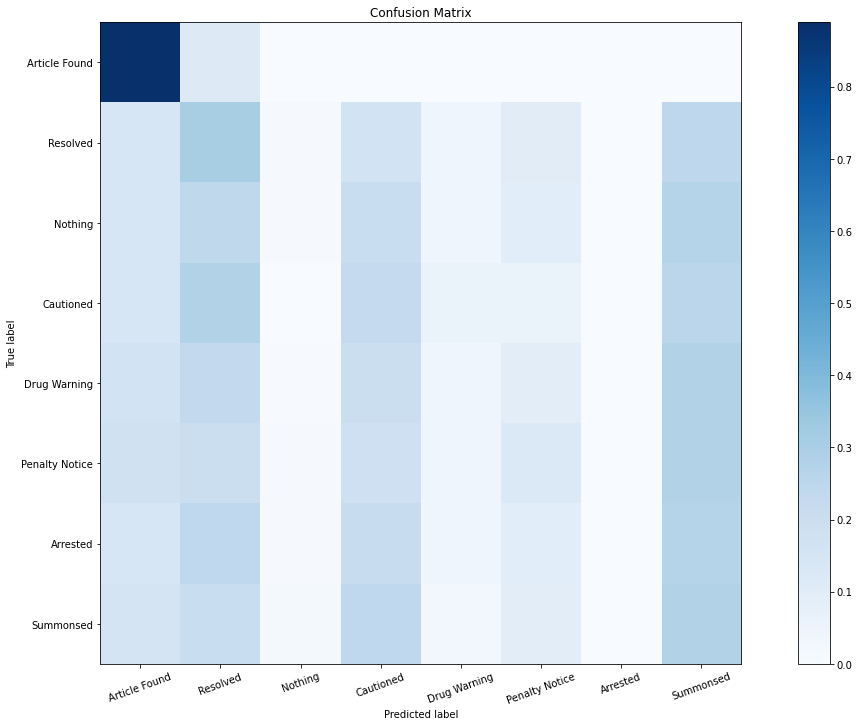

In [45]:
del model
model = load_model(path)

pred = model.predict(X_test2)
pred = np.argmax(pred, axis=1)
# print(f"Prediction\n{pred[:1000]}")
y_test_hot = to_categorical(y_test2)
y_compare = np.argmax(y_test_hot, axis=1) 
# print(f"Y test\n{y_compare[:1000]}")
score = metrics.accuracy_score(y_compare, pred)
print(f"\nScore is {score * 100}")

#Confusion Matrix
util.confusion_plot(y_test=y_compare, y_predictions=pred)

## SMOTE using Binary Classification

Let's see if dividing our classes into just two categories will help improve performance.

<Figure size 1440x360 with 0 Axes>

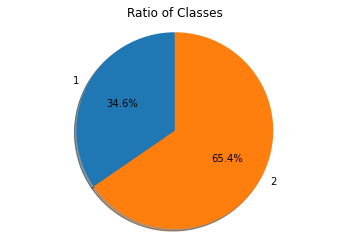

,Type,Date,Latitude,Longitude,Gender,Age range,Officer-defined ethnicity,Legislation,Object of search,Outcome
0,1,1,51.512286,-0.114491,1,1,1,1,8,1
1,1,1,51.512286,-0.114491,1,1,1,1,8,1
2,1,1,51.512286,-0.114491,1,1,1,1,8,1
4,1,2,51.512286,-0.114491,1,1,1,1,8,1
5,1,1,51.512286,-0.114491,1,1,1,1,1,2


In [30]:
#First we binarify the data
data_binary = util.binarify_from_encoded(data_encoded, nothing_value=2)
util.pie_chart_y(data_binary["Outcome"])
data_binary.head()

Split the data

In [20]:
# Xb,yb = util.to_xy(df=data_binary, target="Outcome")
target_b = data_binary["Outcome"]
features_b = data_binary.drop('Outcome', axis=1)

# X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(target_b, features_b, test_size=0.2, random_state=10)

Use smote to decrease frequency of the class "2" ("Nothing found"), and increase all others

In [69]:
# _, frequencies = np.unique(data_binary["Outcome"], return_counts=True)
# print(frequencies)

[ 57298 108353]


109796


<Figure size 1440x360 with 0 Axes>

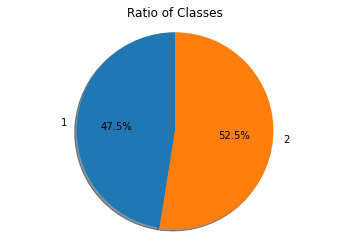

In [60]:
under_sample = RandomUnderSampler(sampling_strategy=0.9)
over_sample = SMOTE(sampling_strategy=0.6)

# Pipeline
steps = [('o', over_sample), ('u', under_sample)]
pipeline = Pipeline(steps=steps)
# transform the dataset
X_smote_b, y_smote_b = pipeline.fit_resample(features_b, target_b)

X_train_smote_b, X_test_smote_b, y_train_smote_b, y_test_smote_b = train_test_split(X_smote_b, y_smote_b, test_size=0.2, random_state=10)
print(len(X_train_smote_b))
util.pie_chart_y(y_train_smote_b)

In [80]:
model_smote_b = Sequential()
units_per_layer = 1000
model_smote_b.add(Dense(units_per_layer, input_dim=9, activation='sigmoid'))
model_smote_b.add(Dense(units_per_layer, activation='sigmoid')) # Hidden 1
# model_smote_b.add(Dense(units_per_layer, activation='sigmoid')) # Hidden 2
model_smote_b.add(Dense(1, activation='softmax'))
model_smote_b.compile(loss='categorical_crossentropy', optimizer='adam')

Xb_shape

In [81]:
%%time
model_smote_b.fit(X_train_smote_b, y_train_smote_b ,verbose=0, epochs=128)

CPU times: user 2h 57min 15s, sys: 27min 19s, total: 3h 24min 35s
Wall time: 35min 10s


In [82]:
y_test = np.array(y_test_smote_b)
pred_smote_b = model_smote_b.predict(X_test_smote_b)
print(len(y_test))
print(y_test)
print(len(pred_smote_b))
print(pred_smote_b)
score = metrics.accuracy_score(y_test, pred_smote_b)
print(f"\nScore is {score}")

27449
[1 1 2 ... 1 1 2]
27449
[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]

Score is 0.4690516958723451
